<a href="https://colab.research.google.com/github/dr-kinder/playground/blob/master/poisson-with-fenicsx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Finite Element Method

To solve hard electrodynamics problems, we are going to use the finite element method.  It requires some custom libraries.  The ones below are open-source projects with state-of-the-art implementations.

The `try ... except` lines below will attempt to import the libraries we need.  If they are not found, they will download and install the libraries.  These commands have been tested on CoLab.  They probably won't work properly elsewhere.

It takes a little while to download and install the libraries, so hit "Play" on the next three cells, relax and grab a cup of coffee, and finish checking your email.  Then get ready to solve some boundary value problems!

The installation commands come from the [FEM on CoLab](https://fem-on-colab.github.io/index.html) project.

In [1]:
try:
    # Import gmsh library for generating meshes.
    import gmsh
except ImportError:
    # If it is not available, install it.  Then import it.
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh

In [2]:
try:
    # Import FEniCSx libraries for finite element analysis.
    import dolfinx
except ImportError:
    # If they are not found, install them.  Then import them.
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

In [3]:
try:
    # Import multiphenicsx, mainly for plotting.
    import multiphenicsx
except ImportError:
    # If they are not found, install them.
    !pip3 install "multiphenicsx@git+https://github.com/multiphenics/multiphenicsx.git@8b97b4e"
    import multiphenicsx

In [4]:
# Everything should be installed, if it was missing.
# Import the rest of what we need.

import dolfinx.fem
import dolfinx.io
import gmsh
import mpi4py.MPI
import numpy as np
import petsc4py.PETSc
import ufl
import multiphenicsx.fem
import multiphenicsx.io

Generate the mesh.

In [5]:
# Define the center of the circle.
x0 = 0
y0 = 0
z0 = 0

# Define the radius of the circle.
r0 = 3

# The function can make ellipses.
# Set these equal to each other for a circle.
rX = r0
rY = r0

# Tell the modeling program how many dimensions we are using.
dim = 2

# Grid size parameter.
delta = 0.25

In [16]:
# Create a model.
gmsh.initialize()
gmsh.model.add("mesh")

In [17]:
## First method of defining model

# Define center of circle and two points on opposite sides.
p0 = gmsh.model.geo.addPoint(x0,y0, z0, delta)
p1 = gmsh.model.geo.addPoint(x0, y0-r0, z0, delta)
p2 = gmsh.model.geo.addPoint(x0, y0+r0,z0, delta)

# Define two semicircular arcs that will be joined into a circle.
c0 = gmsh.model.geo.addCircleArc(p1, p0, p2)
c1 = gmsh.model.geo.addCircleArc(p2, p0, p1)
loop = gmsh.model.geo.addCurveLoop([c0,c1])

## Alternate geometry: semicircle
# l0 = gmsh.model.geo.addLine(p2, p1)
# loop = gmsh.model.geo.addCurveLoop([c0, l0])

disk = gmsh.model.geo.addPlaneSurface([loop])

gmsh.model.geo.synchronize()

gmsh.model.addPhysicalGroup(1, [c0,c1], 1)
gmsh.model.addPhysicalGroup(2, [disk], 1)

1

In [ ]:
## Second method.
# Create the disk.
disk = gmsh.model.occ.addDisk(x0, y0, z0, rX, rY)
loop = gmsh.model.occ.addCircle(x0, y0, z0, r0)
gmsh.model.occ.synchronize()

# Now we will make the disk a physical object in our model --- not just a set of points.
gmsh.model.addPhysicalGroup(2, [disk], 1)

# And we will add the boundary, too.
gmsh.model.addPhysicalGroup(1, [loop], 1)

In [18]:
# Create a mesh for this system.
gmsh.model.mesh.generate(dim)

# Bring the mesh into FEniCSx.
mesh, subdomains, boundaries = dolfinx.io.gmshio.model_to_mesh(
    gmsh.model, comm=mpi4py.MPI.COMM_WORLD, rank=0, gdim=2)

# Close the mesh generating program.
gmsh.finalize()

In [19]:
multiphenicsx.io.plot_mesh(mesh)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [20]:
multiphenicsx.io.plot_mesh_tags(subdomains)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [21]:
multiphenicsx.io.plot_mesh_tags(boundaries)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Here, we import the library for creating meshes and initialize.

Next, we will add a circular membrane to our model.

Next, we are going to bring our model into the finite element solving world.

Define a set of functions on our grid.

In [24]:
# Define trial and test functions
V = dolfinx.fem.FunctionSpace(mesh, ("Lagrange", 2))
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

Define the charge density.  We will use a Gaussian charge distribution.  You can adjust the center and the spread of the distribution.

In [46]:
# Set the values: center and spread charge of charge distribution.
xC = 0.3
yC = 0.2
ds = 0.1
Q = 1

# Turn them into symbolic expressions for the FEM solver.
x = ufl.SpatialCoordinate(mesh)
beta = dolfinx.fem.Constant(mesh, petsc4py.PETSc.ScalarType(1/ds))
X0 = dolfinx.fem.Constant(mesh, petsc4py.PETSc.ScalarType(xC))
X1 = dolfinx.fem.Constant(mesh, petsc4py.PETSc.ScalarType(yC))

# Generate the charge density.
rho = Q * ufl.exp(-0.5 * beta**2 * ((x[0]-X0)**2 + (x[1] - X1)**2))

Next, we need to tell the solver about boundary conditions.

In [47]:
# Identify the domain.
Omega = subdomains.indices[subdomains.values == 1]

# Identify the boundary.
dOmega = boundaries.indices[boundaries.values == 1]

# Use these objects to tell fenics where the boundary is.
boundary_elements = dolfinx.fem.locate_dofs_topological(V, boundaries.dim, dOmega)

# Now introduce the boundary condition: constant potential on the boundary.
phi0 = 0
Phi0 = dolfinx.fem.Constant(mesh, petsc4py.PETSc.ScalarType(phi0))
bc = dolfinx.fem.dirichletbc(Phi0, boundary_elements, V)

Next, tell the solver what problem to solve.

In [48]:
# This is the FEM version of the Laplacian.
a = ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx

# This is the charge density, for Poisson's equation.
L = rho * v * ufl.dx

# Explain the problem to the FEM solver.
uh = dolfinx.fem.Function(V)
problem = dolfinx.fem.petsc.LinearProblem(a, L, bcs=[bc], u=uh, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})

# Now, solve it!
problem.solve()
uh.vector.ghostUpdate(addv=petsc4py.PETSc.InsertMode.INSERT, mode=petsc4py.PETSc.ScatterMode.FORWARD)

We can plot the charge density.  First, we have to interpolate the symbolic expression onto our grid.

In [49]:
# Interpolate the charge density for plotting.
expr = dolfinx.fem.Expression(rho, V.element.interpolation_points())
charge_density = dolfinx.fem.Function(V)
charge_density.interpolate(expr)

# Now, plot it.
multiphenicsx.io.plot_scalar_field(charge_density, "u", 10)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [51]:
# Plot the solution.
multiphenicsx.io.plot_scalar_field(uh, "u", 50)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

We can compare the charge distribution and the potential on the same axes.  This is a little complicated, because we have to determine the value of our grid functions at every point along a line.

As we saw when exploring scalar fields, there are many ways to visualize the result.  Let's plot along a line.

In [64]:
# Avoid hitting the outside of the domain.
buffer = 0.1
num_points = 201

r = np.linspace(-r0 + buffer, r0 - buffer, num_points)
theta = np.arctan(yC/xC)

x = r * np.cos(theta)
y = r * np.sin(theta)

points = np.zeros((3, num_points))
points[0] = x
points[1] = y
v_values = []
rho_values = []

In [65]:
from dolfinx import geometry

# This is an object that makes searching the mesh faster.
bb_tree = geometry.BoundingBoxTree(mesh, mesh.topology.dim)

In [66]:
# Move through the cells and find the points we need.
cells = []
points_on_proc = []

# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions(bb_tree, points.T)

# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(mesh, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i))>0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])

In [67]:
# Evaluate the functions on the cells we found.
points_on_proc = np.array(points_on_proc, dtype=np.float64)
v_values = uh.eval(points_on_proc, cells)
rho_values = charge_density.eval(points_on_proc, cells)

# Scale the two arrays so they fit on the same axes.
scale_factor = rho_values.max() / v_values.max()

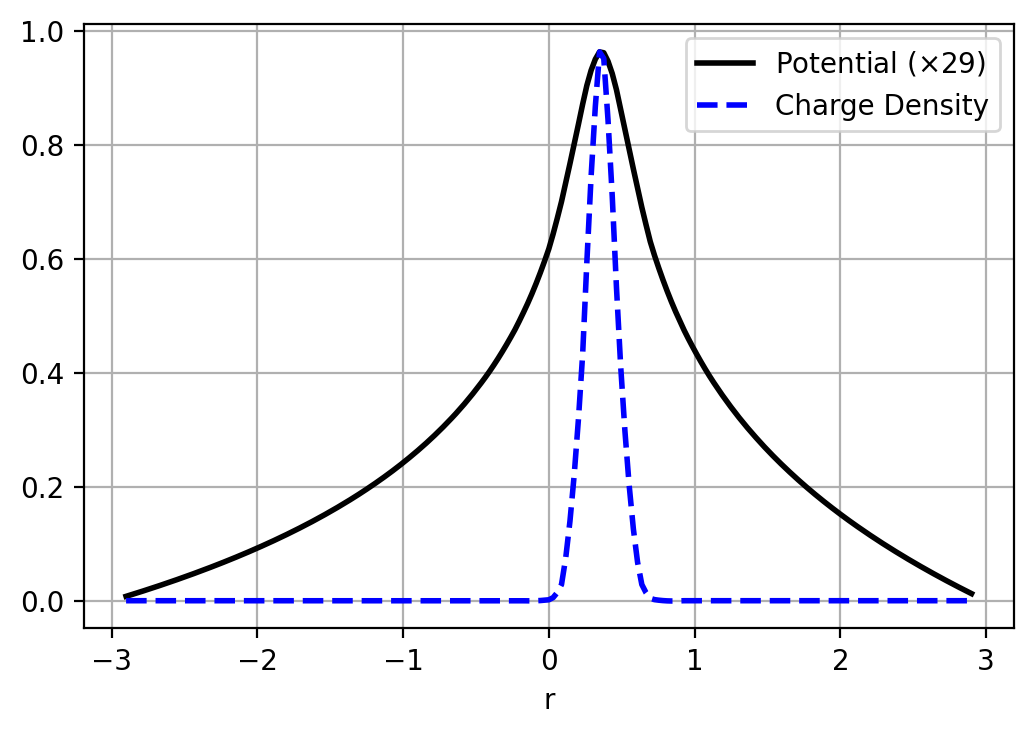

In [68]:
# Make the plot.
import matplotlib.pyplot as plt
fig = plt.figure(dpi=200)
plt.plot(r, scale_factor*v_values, "k", linewidth=2, label="Potential ($\\times %.0f$)" % scale_factor)
plt.plot(r, rho_values, "b--", linewidth = 2, label="Charge Density")
plt.grid(True)
plt.xlabel("r")
plt.legend()

In [ ]:
sphere.points?